# CFM Volatility Prediction in Financial Markets

This notebook implements a  model for CFM Volatility Prediction Challenge (https://challengedata.ens.fr/en/challenge/34/volatility_prediction_in_financial_markets.html).

In [21]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score ,mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

%matplotlib inline

## Load the data

In [2]:
train_X = pd.read_csv('training_input.csv', sep=';')
train_y = pd.read_csv('challenge_34_cfm_trainingoutputfile.csv', sep=',',index_col='ID')
test_X  = pd.read_csv('input_test.csv', sep=',')

In [3]:
display(train_X,train_y,test_X)

,ID,date,product_id,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,...,return 13:10:00,return 13:15:00,return 13:20:00,return 13:25:00,return 13:30:00,return 13:35:00,return 13:40:00,return 13:45:00,return 13:50:00,return 13:55:00
0,1,1,1,0.662737,0.716896,0.698601,0.480172,0.623665,0.201876,0.327206,...,1.0,1.0,1.0,-1.0,1.0,-1.0,0.0,1.0,1.0,-1.0
1,2,1,2,0.285394,0.379560,0.094858,0.094794,0.055315,0.173994,0.102745,...,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0
2,3,1,3,1.151646,1.093562,1.833443,0.595823,0.310177,0.792310,0.401979,...,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0
3,4,1,4,0.835260,0.329615,0.340366,0.216692,0.350371,0.247594,0.341194,...,-1.0,1.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,5,1,5,0.274185,0.061076,0.010168,0.060890,0.000000,0.213162,0.162763,...,-1.0,1.0,1.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636308,636309,2117,314,0.445187,0.440826,0.197667,0.287851,0.377562,0.406626,0.203188,...,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0
636309,636310,2117,315,0.151186,0.160654,0.189244,0.104012,0.132380,0.085103,0.170077,...,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0
636310,636311,2117,316,0.272429,0.215522,0.198277,0.543331,0.098376,0.295860,0.109611,...,1.0,-1.0,-1.0,0.0,-1.0,0.0,1.0,1.0,1.0,-1.0
636311,636312,2117,317,0.483781,0.096898,0.194044,0.135702,0.000000,0.038793,0.000000,...,0.0,0.0,0.0,0.0,NaN,0.0,1.0,NaN,-1.0,0.0


,TARGET
ID,
1,0.134168
2,0.046126
3,0.144312
4,0.130176
5,0.085873
...,...
636309,0.213932
636310,0.165349
636311,0.222322


,ID,eqt_code,date,09:30:00,09:35:00,09:40:00,09:45:00,09:50:00,09:55:00,10:00:00,...,14:35:00,14:40:00,14:45:00,14:50:00,14:55:00,15:00:00,15:05:00,15:10:00,15:15:00,15:20:00
0,745327,975514820,1187660213,-5.765868,-0.496553,0.852754,-0.354230,0.567489,-0.070792,-0.637290,...,0.566192,0.282522,-0.070559,0.070577,-0.070559,0.282307,-0.211516,0.000000,-0.423354,0.847996
1,745328,975514820,4075379637,-0.118653,-1.064350,1.176763,-1.236418,0.737534,-0.528558,0.273105,...,0.462204,-0.131886,0.127535,-0.019407,0.091653,0.652775,-0.080896,0.154637,0.028959,-0.402765
2,745329,975514820,1509397268,2.129608,2.576919,0.096924,0.038237,0.502499,-0.843588,0.012090,...,0.114274,NaN,-0.013945,0.254572,-0.081304,-0.117928,0.154551,0.084374,-0.048784,0.087395
3,745330,975514820,3930524002,-3.721837,-0.683264,0.160819,0.481751,0.107608,-1.526547,1.173124,...,0.065752,-0.633331,-0.022578,0.366928,-0.492304,-0.115243,0.434085,0.154235,-0.495052,-0.808245
4,745331,975514820,3466359530,-28.674284,1.121113,3.280041,-1.320061,-1.451639,0.581340,-1.300371,...,0.300869,0.333145,0.495460,1.120881,0.198488,0.077289,0.321886,-1.443179,0.454032,0.684609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319764,1065091,3926613098,3977320525,2.307960,1.311430,-0.352834,-0.169391,-1.898996,-0.824078,0.697915,...,-0.193431,-0.294737,0.000845,-0.143966,-0.214983,0.224512,0.311350,-0.507967,0.334327,0.014172
319765,1065092,3926613098,3548746336,0.464843,1.156171,-0.000722,-1.284059,0.037770,0.392879,0.336818,...,0.340602,-0.397387,0.197881,0.115861,-0.058711,0.245793,-0.251116,0.006233,0.166612,-0.102210
319766,1065093,3926613098,3397533972,-0.968392,-0.056668,0.030678,-0.329006,-0.689491,-0.566535,0.507696,...,0.078327,-0.164906,-0.060932,0.082905,-0.122271,0.174714,0.059833,0.329992,0.165093,0.135065
319767,1065094,3926613098,4284846807,2.303538,-0.911480,0.462269,0.278449,-0.505121,-0.215297,-0.861238,...,0.509414,-0.047933,0.060436,0.112050,-0.056825,-0.169431,-0.320770,0.104212,-0.124197,0.065293


## Impute missing values

Since we will not use the returns in this simple model, we can simply drop them :

In [4]:
train_X = train_X.drop(train_X.columns[57:], axis=1)
test_X  = test_X.drop(test_X.columns[57:], axis=1)

We linearly interpolate the NaNs corresponding to volatilities :

In [5]:
train_X.iloc[:,3:] = train_X.iloc[:,3:].interpolate(axis=1)
test_X.iloc[:,3:]  = test_X.iloc[:,3:].interpolate(axis=1)

The 09:30 and 13:55 volatilities cannot be interpolated, so we simply replace them by 0 :

In [6]:
train_X.fillna(0, inplace=True) 
test_X.fillna(0, inplace=True)

<div id="pre-processing">
        <h2 style="color:#1a1a1a;
                    font-size:2em">
         ⮞  Construction des modèles
        </h2>
</div>

In [7]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
train_X = train_X.merge(train_y, on='ID')
train_X.drop(['ID', 'date', 'product_id'], axis=1, inplace=True)

train_X_, test_X_, train_y_, test_y_ = train_test_split(train_X.iloc[:,:-1], train_X['TARGET'], test_size=0.2, random_state=42)

### Weighted Linear Regression

In [9]:
regrLinWeighted = LinearRegression()
regrLinWeighted.fit(train_X_, train_y_, sample_weight=(1./train_y_))

LinearRegression()

In [10]:
print('Train error =', round(MAPE(train_y_, regrLinWeighted.predict(train_X_)), 4), '%')
print('Test error  =', round(MAPE(test_y_, regrLinWeighted.predict(test_X_)), 4), '%')

Train error = 23.5619 %
Test error  = 23.8753 %


In [12]:
LR=LinearRegression()

XGBoost = XGBRegressor(n_estimators=100, learning_rate=0.3,
                     max_delta_step=0, max_depth=6, n_jobs=4,
                     num_parallel_tree=1, random_state=0)

RFR = RandomForestRegressor(max_depth=1000, n_jobs=4)
models = {"Linear Regression":LR, "XGBoost Regressor":XGBoost, "Random Forest Regressor":RFR}

In [13]:
def train_model(model_name):
    models[model_name].fit(train_X_,train_y_)
    predictions = models[model_name].predict(test_X_)
    print("\n---------------"+model+"---------------\n")
    
    print('Train error =', round(MAPE(train_y_, models[model_name].predict(train_X_)), 4), '%')
    print('Test error  =', round(MAPE(test_y_, models[model_name].predict(test_X_)), 4), '%')


In [14]:
for model in models:
    train_model(model)


---------------Linear Regression---------------

Train error = 26.2307 %
Test error  = 26.5041 %

---------------XGBoost Regressor---------------

Train error = 26.3286 %
Test error  = 27.7544 %

---------------Random Forest Regressor---------------

Train error = 10.2363 %
Test error  = 28.1086 %


<div id="LSTM">
        <h3 style="color:#1a1a1a;
                    font-size:2em">
             ⮞  MLP
        </h3>
</div>

In [72]:
def create_mlp_model(hidden_size, win_size):
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(win_size,), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(1))
    model.summary()
    return model


In [73]:
hidden_size=128
model = create_mlp_model(hidden_size, 54)
model.compile(loss='mean_absolute_percentage_error', optimizer=Adam(learning_rate=0.001))

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True,
)

history = model.fit(
    train_X_, train_y_, epochs=200, batch_size=32,
    validation_data=(test_X_, test_y_), shuffle=True,
    callbacks=[es],
)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               7040      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
15908/15908 [==============================] - 45s 3ms/step - loss: 24.5119 - val_loss: 23.6906
Epoch 2/200
15908/15908 [==============================] - 44s 3ms/step - loss: 23.9477 - val_loss: 23.5894
Epoch 3/200
15908/15908 [==============================] - 44s 3ms/step - loss: 23.8746 - val_loss:

In [74]:
train_pred = model.predict(train_X_)
test_pred = model.predict(test_X_)
print('Train error =', round(MAPE(np.squeeze(train_y_), np.squeeze(train_pred))), '%')
print('Test error  =', round(MAPE(np.squeeze(test_y_), np.squeeze(test_pred))), '%')

3977/3977 [==============================] - 6s 2ms/step
Train error = 23 %
Test error  = 23 %


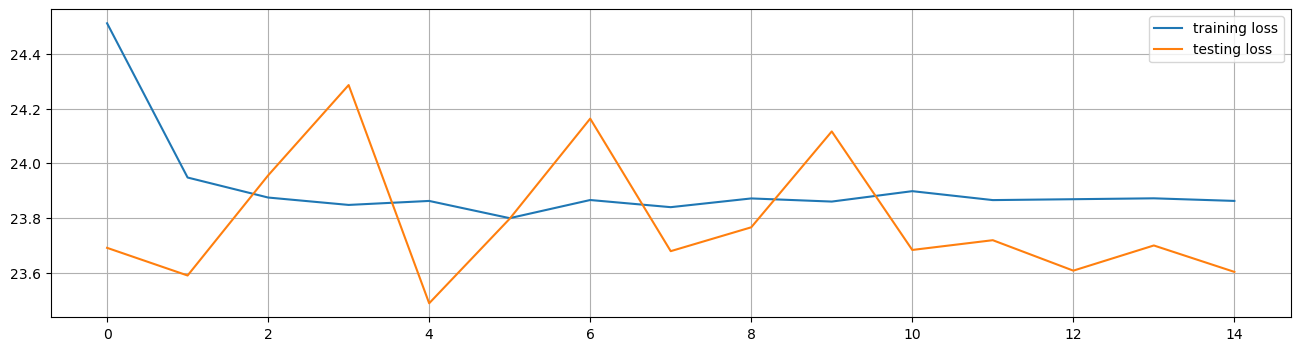

In [75]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 4))
tags = ['loss']
plt.plot(history.history[f'{tags[n]}'], label=f'training {tags[n]}')
plt.plot(history.history[f'val_{tags[n]}'], label=f'testing {tags[n]}')
plt.legend()
plt.grid()
plt.show()

## Prediction with MLP

In [89]:
test_X.drop(columns='PREDICT',inplace=True)

In [90]:
test_X['PREDICT'] = model.predict(test_X.iloc[:,3:])

9993/9993 [==============================] - 17s 2ms/step


In [93]:
test_X.to_csv('predictions.csv', sep=',', index=False)

<div id="LSTM">
        <h3 style="color:#1a1a1a;
                    font-size:2em">
             ⮞  LSTM
        </h3>
</div>

Après avoir appliqué le modèle de régression linéaire à nos données, nous allons essayer d'implémenter un modèle de deep learning : LSTM qui est très adapté à ce cas.

In [69]:
def lstm_model():
    LSTM_model=Sequential()
    LSTM_model.add(LSTM(100,input_shape=(54,1), return_sequences=False,activation="relu"))
    #LSTM_model.add(LSTM(100, return_sequences=True))
    #LSTM_model.add(LSTM(100, return_sequences=False))
    #LSTM_model.add(Dense(25))
    model.add(tf.keras.layers.Dropout(0.2))
    LSTM_model.add(Dense(1))
    LSTM_model.summary()
    return LSTM_model

In [70]:
model2 = lstm_model()
model2.compile(loss='mean_absolute_percentage_error', optimizer=Adam(learning_rate=0.001))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100)               40800     
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True,
)

history = model2.fit(
    train_X_, train_y_, epochs=100, batch_size=50,
    validation_data=(test_X_, test_y_), shuffle=True,
    callbacks=[es],
)

In [ ]:
train_pred = model.predict(train_X_)
test_pred = model.predict(test_X_)
print('Train error =', round(MAPE(np.squeeze(train_y_), np.squeeze(train_pred))), '%')
print('Test error  =', round(MAPE(np.squeeze(test_y_), np.squeeze(test_pred))), '%')

In [ ]:
fig = plt.figure(figsize=(16, 4))
tags = ['loss']
plt.plot(history.history[f'{tags[n]}'], label=f'training {tags[n]}')
plt.plot(history.history[f'val_{tags[n]}'], label=f'testing {tags[n]}')
plt.legend()
plt.grid()
plt.show()

## Prediction

In [ ]:
from sklearn.linear_model import LinearRegression

regrLinWeighted = LinearRegression()
regrLinWeighted.fit(train_X.iloc[:,:-1], train_X['TARGET'], sample_weight=(1./train_X['TARGET']))

test_X['PREDICT'] = regrLinWeighted.predict(test_X.iloc[:,3:])

In [ ]:
predictions = test_X[['ID', 'PREDICT']]
predictions.columns = ['ID', 'TARGET']

In [ ]:
predictions.to_csv('predictions.csv', sep=';', index=False)